In [1]:
'''
import os
if(os.getcwd() != '/content'):
  os.chdir('/content')

os.getcwd()
'''

"\nimport os\nif(os.getcwd() != '/content'):\n  os.chdir('/content')\n\nos.getcwd()\n"

In [2]:
'''
from google.colab import drive
drive.mount("/content/drive")
'''

'\nfrom google.colab import drive\ndrive.mount("/content/drive")\n'

In [3]:
#!git clone https://github.com/openai/baselines.git

In [4]:
#!pip install gym[atari]

In [5]:
'''
!pip install atari-py
!apt-get install -y wget

# Download the Atari ROMs
!wget -P /content/ http://www.atarimania.com/roms/Atari-2600-VCS-ROM-Collection.zip
# Unzip the ROMs
!unzip -o Atari-2600-VCS-ROM-Collection.zip

# Remove the downloaded zip file
!rm /content/Atari-2600-VCS-ROM-Collection.zip
'''

'\n!pip install atari-py\n!apt-get install -y wget\n\n# Download the Atari ROMs\n!wget -P /content/ http://www.atarimania.com/roms/Atari-2600-VCS-ROM-Collection.zip\n# Unzip the ROMs\n!unzip -o Atari-2600-VCS-ROM-Collection.zip\n\n# Remove the downloaded zip file\n!rm /content/Atari-2600-VCS-ROM-Collection.zip\n'

In [6]:
'''
import os

# Change to the baselines directory
os.chdir('baselines')

# Install the baselines package
!pip install -e .
os.chdir('..')
'''

"\nimport os\n\n# Change to the baselines directory\nos.chdir('baselines')\n\n# Install the baselines package\n!pip install -e .\nos.chdir('..')\n"

In [7]:
#!python -m atari_py.import_roms "/content/ROMS"

In [8]:
'''
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
    '''

'\nif type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:\n    !bash ../xvfb start\n    %env DISPLAY=:1\n    '

In [9]:
'''
import os
if not os.path.exists('drive/MyDrive/dqn_breakout/v2'):
    os.makedirs('drive/MyDrive/dqn_breakout/v2')

os.chdir('drive/MyDrive/dqn_breakout')
os.getcwd()
'''

"\nimport os\nif not os.path.exists('drive/MyDrive/dqn_breakout/v2'):\n    os.makedirs('drive/MyDrive/dqn_breakout/v2')\n\nos.chdir('drive/MyDrive/dqn_breakout')\nos.getcwd()\n"

In [10]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import gym
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import random
import os
import pickle
import copy
import gc

In [11]:
print(tf.__version__)

2.10.1


In [12]:
print(gym.__version__)

0.15.7


# CONCETTI PRINCIPALI DQN

![POLICY_NETWORK](images/policy_network.png)<br>
Dopo aver memorizzato un'esperienza nella replay memory, si procede a campionare una batch casuale di esperienze dalla replay memory.
A partire da un singolo campione (generalizzando a una batch) di esperienza dalla memoria, si procede a una preelaborazione dello stato (conversione in scala di grigi, ritaglio, scalatura, ecc.) e si passa lo stato preelaborato alla rete come input. L'obiettivo della rete è quello di approssimare la policy ottimale trovando la Q-function ottimale.

I dati dello stato di input vengono propogati nella rete e vengono calcolati i Q-values per ciascuna azione in quello stato.

Si calcola quindi la loss. Per farlo, si confronta il valore Q emesso dalla rete per l'azione nella tupla di esperienza che abbiamo campionato e il corrispondente valore Q ottimale, o valore Q target, per la stessa azione.

Il valore Q target viene calcolato utilizzando l'espressione del lato destro dell'equazione di Bellman. Quindi la loss viene calcolata sottraendo il valore Q per una data coppia stato-azione dal valore Q ottimale per la stessa coppia stato-azione.

![TARGET_NETWORK](images/target_network.png)<br>
Per calcolare il target Q-value viene fatto un altro forward pass prendendo lo stato s' (next state) dalla tupla dell'esperienza campionata. Viene utilizzata una seconda rete (TARGET NETWORK), una copia della policy network (copia dei pesi dalla policy network periodicamente). Viene preso il Q-value massimo tra le possibili azioni.

Questo secondo forward pass serve quindi per aiutarci a calcolare la loss.

La discesa del gradiente viene quindi eseguita per aggiornare i pesi della rete nel tentativo di minimizzare la perdita. In questo caso, minimizzare la perdita significa puntare a far sì che la rete produca valori Q per ogni coppia stato-azione che si avvicinino ai valori Q target dati dall'equazione di Bellman.

Fino a questo punto, tutto ciò che abbiamo esaminato riguardava un singolo passo temporale. Passiamo quindi alla fase temporale successiva dell'episodio e ripetiamo questo processo più volte, finché non raggiungiamo la fine dell'episodio. A quel punto, iniziamo un nuovo episodio e continuiamo a farlo finché non raggiungiamo il numero massimo di episodi stabilito. Continueremo a ripetere questo processo fino a quando non avremo minimizzato a sufficienza la perdita.

RECAP

![algorithm](images/algorithm.png)<br>

In [13]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
#tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [15]:
seed = 42
# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)
env.reset()

C:\Users\Livio\anaconda3\envs\dqn-breakout\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [16]:
state_dim = env.observation_space.shape
state_dim

(84, 84, 4)

In [17]:
n_actions = env.action_space.n
n_actions

4

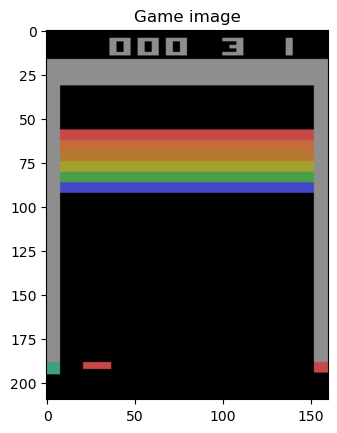

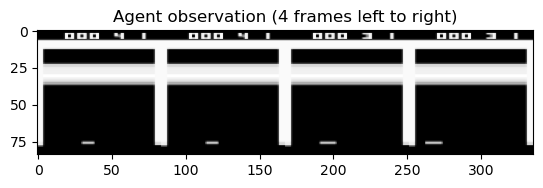

In [18]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

obs = np.array(obs)
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]), cmap='Greys_r');

# DEEP Q-NETWORK

In [19]:
#V1
'''
from keras.layers import Conv2D, Dense, Flatten

def create_qmodel(state_shape, n_actions):
    network = keras.models.Sequential()

    # Keras ignores the first dimension in the input_shape, which is the batch size.
    # So just use state_shape for the input shape
    network.add(Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=state_shape))
    network.add(Conv2D(64, (4, 4), strides=2, activation='relu'))
    network.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    network.add(Flatten())
    network.add(Dense(512, activation='relu'))
    network.add(Dense(n_actions, activation='linear'))

    return network
'''

"\nfrom keras.layers import Conv2D, Dense, Flatten\n\ndef create_qmodel(state_shape, n_actions):\n    network = keras.models.Sequential()\n\n    # Keras ignores the first dimension in the input_shape, which is the batch size.\n    # So just use state_shape for the input shape\n    network.add(Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=state_shape))\n    network.add(Conv2D(64, (4, 4), strides=2, activation='relu'))\n    network.add(Conv2D(64, (3, 3), strides=1, activation='relu'))\n    network.add(Flatten())\n    network.add(Dense(512, activation='relu'))\n    network.add(Dense(n_actions, activation='linear'))\n\n    return network\n"

In [20]:
#V2
from keras.layers import Conv2D, Dense, Flatten

def create_qmodel(state_shape, n_actions):
    network = keras.models.Sequential()
    # Keras ignores the first dimension in the input_shape, which is the batch size.
    # So just use state_shape for the input shape
    network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
    network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
    network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
    network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
    network.add(Flatten())
    network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))

    return network

# REPLAY MEMORY

In [21]:
# This code is shamelessly stolen from https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

# EPSILON GREEDY STRATEGY

In [22]:
class EpsilonGreedyStrategy():
    def __init__(self, current, max, min, epsilon_random_frames, epsilon_greedy_frames):
        self.current = current
        self.max = max
        self.min = min
        self.epsilon_random_frames = epsilon_random_frames
        self.epsilon_greedy_frames = epsilon_greedy_frames

    def decay_epsilon(self):
        # Decay probability of taking random action
        self.current -= (self.max - self.min)/self.epsilon_greedy_frames
        return self.current

# AGENT CLASS

In [23]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        action = 0
        epsilon = self.strategy.current

        if epsilon > random.random() or self.current_step < self.strategy.epsilon_random_frames:
            action = random.randrange(self.num_actions) #explore
        else:
            action_probs = policy_net(state, training=False)
            # Take best action
            act = tf.argmax(action_probs[0]).numpy() #exploit
            #print(action)
            action = act

        epsilon = self.strategy.decay_epsilon()
        self.strategy.current = max(epsilon, self.strategy.min)
        self.current_step += 1

        return action        

In [24]:
def save_agent(agent, save_path, save_name):
    # Create folder if it does not exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save the entire object to a file using pickle
    with open(os.path.join(save_path, save_name) + '.pkl', 'wb') as file:
        pickler = pickle.Pickler(file)
        pickler.dump(agent)

def load_agent(load_path, load_name):
    # Load the entire object from the file using pickle
    with open(os.path.join(load_path, load_name) + '.pkl', 'rb') as file:
        loaded_agent = pickle.load(file)

    return loaded_agent

# HYPER-PARAMETERS

In [25]:
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
update_after_actions = 4
#num_episodes = 1000
max_steps_per_episode = 10000
update_target_network = 10000
batch_size = 64
gamma = 0.99
max_memory_length = 100000

In [26]:
policy_net = create_qmodel(state_dim, n_actions)
target_net = create_qmodel(state_dim, n_actions)
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = keras.losses.Huber()
strategy = EpsilonGreedyStrategy(current = epsilon,
                                     max = epsilon_max,
                                     min = epsilon_min,
                                     epsilon_random_frames = epsilon_random_frames,
                                     epsilon_greedy_frames = epsilon_greedy_frames)

agent = Agent(strategy, n_actions)
#ho commentato altrimenti ho problemi di RAM sul mio pc, non su colab 
#memory = ReplayBuffer(max_memory_length)

In [27]:
#checkpoints modello e optimizer, per eseguire run successive
ckpt = tf.train.Checkpoint(model=policy_net, optimizer=optimizer)
manager = tf.train.CheckpointManager(ckpt, './v2/tf_ckpts', max_to_keep=3)

agent_dir = './v2/agent'

In [28]:
from tqdm import trange

def play_and_record(agent, policy_net, env, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    """
    # State at the beginning of rollout
    s = np.array(env.reset())

    # Play the game for n_steps as per instructions above
    for t in trange(n_steps):
        # get agent to pick action given state s
        state_tensor = tf.convert_to_tensor(s)
        state_tensor = tf.expand_dims(state_tensor, 0)
        #seleziona azione tramite strategia epsilon-greedy
        action = agent.select_action(state_tensor, policy_net)
        #print(action)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state)

        # add to replay buffer
        memory.add(s, action, reward, next_state, done)
        if done:
            s = np.array(env.reset())
        else:
            s = next_state

In [29]:
print('Filling replay memory...')
#uncomment to fill replay memory
#play_and_record(agent, policy_net, env, n_steps=20000)
#len(memory)

Filling replay memory...


In [30]:
'''
from datetime import datetime

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./v2/logs/{current_time}'
# Callback per TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

%load_ext tensorboard
%tensorboard --logdir ./v2/logs
'''

'\nfrom datetime import datetime\n\ncurrent_time = datetime.now().strftime("%Y%m%d-%H%M%S")\nlog_dir = f\'./v2/logs/{current_time}\'\n# Callback per TensorBoard\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)\n\n%load_ext tensorboard\n%tensorboard --logdir ./v2/logs\n'

# TRAINING LOOP

In [31]:
from tqdm import trange
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

def train(env, agent, policy_net, target_net, memory, loss_function, optimizer, log_dir, agent_dir, ckpt, manager, resume = False):
    running_reward = 0
    frame_count = 0
    episode_count = 0
    episode_rw_history = []
    td_loss_history = []
    epsilon_history = []

    if(resume):
        ckpt.restore(manager.latest_checkpoint)
        if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
            agent = load_agent(agent_dir, 'agent')
        else:
            print("Initializing from scratch.")


    while True:
        state = np.array(env.reset())
        episode_rw = 0
        for timestep in range(1, max_steps_per_episode):
            #Adding this line would show the attempts
            #env.render();
            # Print the result
            frame_count += 1
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)

            #seleziona azione tramite strategia epsilon-greedy
            action = agent.select_action(state_tensor, policy_net)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array(next_state)
            episode_rw += reward
             # Save actions and states in replay buffer
            memory.add(state, action, reward, next_state, done)
            state = next_state

            if frame_count % update_after_actions == 0 and len(memory) > batch_size:
                # Get samples from replay buffer
                state_sample, action_sample, rewards_sample, next_state_sample, done_sample = memory.sample(batch_size)

                next_qvalues =  target_net.predict(next_state_sample, verbose=0)
                max_next_qvalues = tf.reduce_max(next_qvalues, axis=1)

                #lato destro equazione bellman ford
                target_qvalues = rewards_sample + gamma * max_next_qvalues
                # If final frame set the last value to -1
                target_qvalues = target_qvalues * (1 - done_sample) - done_sample

                with tf.GradientTape() as tape:
                    current_qvalues = policy_net(state_sample)
                    #q-values relativi alle azioni nelle esperienze campionate
                    current_action_qvalues = tf.reduce_sum(tf.one_hot(tf.cast(action_sample, dtype=tf.int32), n_actions) * current_qvalues, axis=1)
                    td_loss = loss_function(target_qvalues, current_action_qvalues)
                 # Backpropagation
                grads = tape.gradient(td_loss, policy_net.trainable_variables)
                optimizer.apply_gradients(zip(grads, policy_net.trainable_variables))
                td_loss_history.append(td_loss)
            #target network update
            if frame_count % update_target_network == 0:
                target_net.set_weights(policy_net.get_weights())
                # Log details
                template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.5f}"
                print(template.format(running_reward, episode_count, frame_count, agent.strategy.current))

                with tf.summary.create_file_writer(log_dir).as_default():
                  tf.summary.scalar('running Reward', running_reward, step = agent.current_step)
                  tf.summary.scalar('Td loss', np.mean(td_loss_history), step = agent.current_step)
                  tf.summary.scalar('Epsilon',agent.strategy.current , step = agent.current_step)


            if frame_count % 100000 == 0:
                save_path = manager.save()
                print("Saved checkpoint for step {}: {}".format(frame_count, save_path))
                save_agent(agent, agent_dir, 'agent')

            if done:
                break


        episode_rw_history.append(episode_rw)
        # Update running reward to check condition for solving
        if len(episode_rw_history) > 100:
            del episode_rw_history[:1]
        running_reward = np.mean(episode_rw_history)

        episode_count += 1

        if running_reward > 40:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break


In [32]:
#train(env,agent, policy_net, target_net, memory, loss_function, optimizer, log_dir, agent_dir, ckpt, manager, resume = False)

Sull'asse X il numero di step e sull'asse Y la running reward (media delle reward cumulate degli ultimi 100 episodi)

### Running Reward training

![POLICY_NETWORK](images/runningRewardV2.svg)

In fase di valutazione il modello è stato valutato con epsilon pari a 0 (ossia scegliendo sempre l'azione con q-value maggiore), il miglior punteggio ottenuto è 358

In [33]:
import time
from tqdm import trange

#Evaluate agents performance, in a number of games
def evaluate(env, policy_net, n_games=1,t_max=1000):
    """ Plays n_games. Returns mean reward. """
    rewards = []
    #state = np.array(env.reset())
    for _ in trange(n_games):
        r = 0
        state = env.reset()
        for _ in range(t_max):
            env.render()
            time.sleep(.1)
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_q = policy_net(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_q[0]).numpy() #exploit
            next_state, reward, done, _ = env.step(action)
            next_state = np.array(next_state)
            r += reward

            if done:
              #state = env.reset()
              break

            else:
                state = next_state

        rewards.append(r)

    env.close()
    return np.mean(rewards)

In [34]:
#agent = load_agent(agent_dir, 'agent')
policy_net.load_weights('./trained_model.h5')
#ckpt.restore('./v2/tf_ckpts/ckpt-46')
#policy_net.save_weights('./weights/v2_best_trained_model.h5', overwrite=True)

In [ ]:
results = evaluate(env, policy_net, n_games = 20)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

In [ ]:
results